# Kickstarter projects classification model

In this coursework ([4iz565](http://4iz565.gitlab.io/)) we will try to find the best model to predict if projects on [Kickstarter](https://www.kickstarter.com/) will be successful or not.

We use dataset from kaggle with more than 300 000 Kickstarter projects.

- [Link to the dataset on kaggle](https://www.kaggle.com/kemical/kickstarter-projects)

## Authors
- Aleksandra Golofaeva (gola03@vse.cz)
- Dmitrij Tkačenko (tkad06@vse.cz)

## Requirements (packages) for running Python scripts
- python3
- pandas
- numpy
- matplotlib
- sklearn
- datetime

## Goal of the classification

In this coursework we try to create classification model, which will **predict if a project from the Kickstarter portal success or fail**.

We preprocess dataset to work just with relevant attributes. We derive new columns and remove redundant ones. Also, we should handle missing values.

Then, we use and compare two fitting and common algorithms to train model.

We select one classifier and tune it's metaparameters.

And finally, we evaluate selected and tuned model.

## Discover dataset

Before we will train any models, we should discover our dataset, then we will proceed to preprocessing our data.

But first, lets import Kickstarter projects dataset from a `.csv` file and save as a pandas data frame `ksp`.

In [111]:
import pandas as pd

# we know that first column is a row ID, so we set index_col to 0.
ksp = pd.read_csv("ks-projects-201801.csv", index_col=0)
# return data frame with our data
ksp.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


We see our target column **state** in above data frame. This categorical attribute will be crucial for us while training prediction model and then testing that model.

Let's see what values it has. We create bar plot here to visualize our target values and their counts.

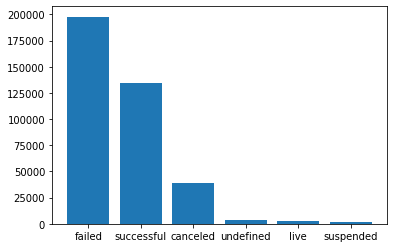

In [112]:
import matplotlib.pyplot as plt

ksp_target_counts = ksp['state'].value_counts()
plt.bar(ksp_target_counts.index, ksp_target_counts.values)
plt.show()

As we see in a bar plot above we have 6 target values here (categories).

- failed - it has reached deadline, but pledge was not fullfilled
- successful
- canceled - canceled by a project owner, before deadline reach
- undefined
- live - project active in the time dataset was created
- suspended - suspended due to Trust & Safety team uncovers evidence that it is in violation of Kickstarter's rules

Now, we know for sure, that we should get rid of rows whose target value is **live**. We can then extract those rows and use them as a test data.

It seems reasonable to transform **canceled** projects to **failed**, same with **suspended**.

Then we will remove rows with **undefined** state, reasons will be shown below.

## Preprocessing

1. We would like to have just two target values - **successful** and **failed**.
2. We remove undefined rows.
3. We derive new columns and remove redundant ones.
4. We handle missing values (if present).
5. Convert categorical columns from string values to numerical. Sklearn does not know how to work witch categorical properly.
6. We extract rows with **live** state and save them to a variable. We will use them for testing in the end.

### Merge states

Here, we set canceled and suspended projects as failed ones.

In [113]:
# create copy for preprocessing
ksp_pre = ksp.copy()

# get current sum of rows for each state
canceled_proj_len = len(ksp_pre[ksp_pre['state'] == 'canceled']) 
suspended_proj_len = len(ksp_pre[ksp_pre['state'] == 'suspended'])
failed_proj_len = len(ksp_pre[ksp_pre['state'] == 'failed'])

# set failed state instead of canceled state
ksp_pre.loc[ksp['state'] == 'canceled', ['state']] = 'failed'
# set failed state instead of suspended state
ksp_pre.loc[ksp['state'] == 'suspended', ['state']] = 'failed'

assert len(ksp_pre[ksp_pre['state'] == 'canceled']) == 0, "Canceled rows length should be 0"
assert len(ksp_pre[ksp_pre['state'] == 'suspended']) == 0, "Suspended rows length should be 0"
assert len(ksp_pre[ksp_pre['state'] == 'failed']) == failed_proj_len + suspended_proj_len + canceled_proj_len
print("Canceled and suspended projects successfully converted to failed projects.")
print("Failed projects sum: ", failed_proj_len + suspended_proj_len + canceled_proj_len)

Canceled and suspended projects successfully converted to failed projects.
Failed projects sum:  238344


### Handle undefined rows

In [114]:
# Print projects with undefined state
ksp_pre[ksp_pre['state'] == 'undefined'].head()
undefined_proj_counts = len(ksp_pre[ksp_pre['state'] == 'undefined'])

All undefined data have null country values. We would like to use country column in our model.

In [115]:
ksp_pre[ksp_pre['country'] == 'N,0"']

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",NaN,10.00,7500.00
998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",NaN,2845.61,2752.04
9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",NaN,235.00,5000.00


We cannot properly set countries of undefined rows, because 

1. Not always currency is corresponding to a country (for example project here https://www.kickstarter.com/projects/1939925037/duncan-woods-chameleon-ep has AUD currency but project is from Germany).
2. We cannot set countries derived from currencies always right, using some general method.

That's why we decided to remove rows with undefined state. There is not many of those, so it won't be a significant loss.


In [116]:
ksp_pre.drop(ksp_pre[(ksp_pre['country'] == 'N,0"') | (ksp_pre['state'] == 'undefined')].index, inplace=True)
assert len(ksp_pre[ksp_pre['country'] == 'N,0"']) == 0, "Data with undefined country should be dropped."
assert len(ksp_pre[ksp_pre['state'] == 'undefined']) == 0, "Data with undefined state should be dropped."
print("✅ Data with undefined country or state (or both) are dropped.")

✅ Data with undefined country or state (or both) are dropped.


### Remove, derive columns

We have here multiple columns, which does not have any meaning for our model or even could have negative effect on our model.

- `name` - A lot of distinct values (could be even unique), not categorical, not numerical.
- `backers` and `pledged` - If one of them is 0, then the other one too. It shows end-state of a project, but in the beginning it always equals to 0. So all new data, that we have to predict will be predicted as Failed.

Column `launched` gives us information about a project beginning datetime on the Kickstarter. It's 99.9% probability that it would be an unique value, because it has even seconds. Also, it gives us nothing for our prediction model.

**BUT We can use `launched` values in the other way.** We have available **deadline** date too. We will derive a new column called **duration**, where we pass the difference between launched and deadline dates. The difference will be presented in days. Thus, duration represents how many days a project was/will be active on the Kickstarter.

Next, we see some duplicated columns.
- `usd_goal_real` -> `goal` converted to $
- `usd_pledged_real` -> `pledged` converted to $ by Fixer.io API
- `usd_pledged` -> `pledged` converted to $ by the kickstarter

We mentioned above that pledged value is useless for us, so duplicate columns like usd_pledged_real and usd_pledged too. We can remove them.

At this point currency column does not make sense for us anymore, because we have all project's goals converted to USD. Country column will do the job for categorization.

Now, we remove mentioned columns.

In [117]:

ksp_pre = ksp_pre.drop(['name', 'currency', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1)

ksp_pre.head()

,category,main_category,deadline,launched,state,country,usd_goal_real
ID,,,,,,,
1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00


At this point we can derive **duration** column and remove `launched` and `deadline` columns.

In [118]:
from datetime import datetime

# get datetime strings, convert them to datetime objects and return duration in days between two days
def parse_and_get_duration_in_days(from_date_str, to_date_str):
    from_date = datetime.strptime(from_date_str, '%Y-%m-%d %H:%M:%S')
    to_date = datetime.strptime(to_date_str, '%Y-%m-%d')
    duration = to_date - from_date
    return duration.days

# create new column duration and use function above to apply duration value derived from launched and deadline columns
ksp_pre['duration'] = ksp_pre.apply(lambda x: parse_and_get_duration_in_days(x['launched'], x['deadline']), axis=1)

ksp_pre.head()

,category,main_category,deadline,launched,state,country,usd_goal_real,duration
ID,,,,,,,,
1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95,58
1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00,59
1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00,44
1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00,29
1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00,55


In the table above we see new `duration` column.

We should handle durations which are less then 24 hours. We round the number up to 1 day (e.g. from 0 to 1). 

In [119]:
duration_zero_df = ksp_pre[ksp_pre['duration'] == 0]
duration_zero_len = len(duration_zero_df)
duration_zero_df

,category,main_category,deadline,launched,state,country,usd_goal_real,duration
ID,,,,,,,,
1004457833,Video Games,Games,2015-06-11,2015-06-10 19:03:39,failed,GB,7743.29,0
1004692921,Classical Music,Music,2016-02-19,2016-02-18 04:29:22,failed,US,500.00,0
1052555922,Software,Technology,2017-03-05,2017-03-04 01:25:03,failed,US,10000000.00,0
1062718053,Film & Video,Film & Video,2016-06-15,2016-06-14 02:24:00,successful,GB,185.73,0
1103482181,Art,Art,2016-04-02,2016-04-01 08:38:27,failed,US,8888.00,0
...,...,...,...,...,...,...,...,...
947786339,Poetry,Publishing,2014-03-02,2014-03-01 13:20:34,successful,GB,8.39,0
959890458,Digital Art,Art,2016-08-02,2016-08-01 21:44:53,successful,SG,3.73,0
967507244,Tabletop Games,Games,2017-08-06,2017-08-05 18:05:40,failed,FR,81.18,0


In [120]:
duration_one_df = ksp_pre[ksp_pre['duration'] == 1]
duration_one_len = len(duration_one_df)
duration_one_df

,category,main_category,deadline,launched,state,country,usd_goal_real,duration
ID,,,,,,,,
1032840025,Drama,Film & Video,2015-05-07,2015-05-05 16:32:26,failed,GB,2312.03,1
1046567430,Games,Games,2015-01-28,2015-01-26 16:40:02,failed,US,500.00,1
1048845117,Tabletop Games,Games,2017-12-24,2017-12-22 21:25:33,successful,US,250.00,1
1051336871,Young Adult,Publishing,2015-04-03,2015-04-01 19:38:46,failed,US,100000.00,1
1083441801,Documentary,Film & Video,2015-07-07,2015-07-05 21:53:50,failed,US,1500.00,1
...,...,...,...,...,...,...,...,...
944352331,Publishing,Publishing,2015-01-15,2015-01-13 05:34:28,successful,CA,415.45,1
972092973,Performance Art,Art,2013-04-20,2013-04-18 08:07:02,failed,US,500.00,1
98041241,Periodicals,Publishing,2013-11-21,2013-11-19 21:00:09,successful,US,1000.00,1


In [121]:
ksp_pre['duration'].replace(0, 1, inplace=True)
assert len(ksp_pre[ksp_pre['duration'] == 0]) == 0
assert len(ksp_pre[ksp_pre['duration'] == 1]) == duration_zero_len + duration_one_len
ksp_pre[ksp_pre['duration'] == 1]

,category,main_category,deadline,launched,state,country,usd_goal_real,duration
ID,,,,,,,,
1004457833,Video Games,Games,2015-06-11,2015-06-10 19:03:39,failed,GB,7743.29,1
1004692921,Classical Music,Music,2016-02-19,2016-02-18 04:29:22,failed,US,500.00,1
1032840025,Drama,Film & Video,2015-05-07,2015-05-05 16:32:26,failed,GB,2312.03,1
1046567430,Games,Games,2015-01-28,2015-01-26 16:40:02,failed,US,500.00,1
1048845117,Tabletop Games,Games,2017-12-24,2017-12-22 21:25:33,successful,US,250.00,1
...,...,...,...,...,...,...,...,...
98041241,Periodicals,Publishing,2013-11-21,2013-11-19 21:00:09,successful,US,1000.00,1
983988118,Publishing,Publishing,2016-02-28,2016-02-27 04:40:59,successful,US,250.00,1
989951025,Design,Design,2012-12-23,2012-12-21 18:00:02,successful,US,13.00,1


Next, we derive column `launched_month` to have information about time of the year a project was launched.

In [122]:
# get datetime strings, convert them to datetime objects and return duration in days between two days
def get_launched_month(launched_date_str):
    launched_date = datetime.strptime(launched_date_str, '%Y-%m-%d %H:%M:%S')
    return launched_date.month

ksp_pre['launched_month'] = ksp_pre.apply(lambda x: get_launched_month(x['launched']), axis=1)

ksp_pre.head()

,category,main_category,deadline,launched,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,,,
1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95,58,8
1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00,59,9
1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00,44,1
1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00,29,3
1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00,55,7


We have derived two new columns from dates provided by the dataset - duration and launched_month.

We can remove launched and deadline columns as we do not need them anymore.

In [123]:
# remove launched and deadline columns
ksp_pre = ksp_pre.drop(['launched', 'deadline'], axis=1)

### Handle missing values

In [124]:
ksp_pre.isna().sum()

category          0
main_category     0
state             0
country           0
usd_goal_real     0
duration          0
launched_month    0
dtype: int64

Above we see that there are no null values.

But we know about not valid values such as `'N,"0'` and `'N,0"` (from our country case or also from older 2016 dataset).

In [125]:
ksp_pre[ksp_pre.isin(['', 'N,"0', 'N,0"']).any(axis=1)]

,category,main_category,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,


But again we see above, that no such values have left.

Next, we wanted to be sure, that no other issues appear in our dataset. We print all unique values of categorical (nominal) data.

In [126]:
for column_name in ('category', 'main_category', 'state', 'country', 'duration'):
    result = ksp_pre[column_name].unique()
    result.sort()
    print(column_name, result)

category ['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin' 'Let

### Categorical to numerical

Now we have to convert our categorical values to numerical for two reasons:

1. Sklearn cannot work with non-numerical categorical data.
2. We do not want to have these as dummies. It results to a lot of new columns (for each value in a category is generated one column) and it significantly increases time of classification model building.

We will apply dummies only for our target column, as it has only two categories, so it will be much easer to create numerical representation of them.

In [127]:
# here we will save all dictionaries so we can use it later (two way mapping)
replace_dictionary = {}

# set columns we want to convert from string categories to numerical categories
columns_to_replace = ['country', 'main_category', 'category']

# help function for converting
def replace_categorical_to_num(column):
    # store category names to a list
    labels = ksp_pre[column].astype('category').cat.categories.tolist()
    # make mapping using dictionary comprehensions ({category: unique number})
    replace_map_comp = {column : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    # just save category dictionary for further usage
    replace_dictionary[column] = replace_map_comp[column]
    # use mapping function to replace categories for unique numbers
    ksp_pre.replace(replace_map_comp, inplace=True)

# iterate through columns and call help function
for c in columns_to_replace:
    replace_categorical_to_num(c)

ksp_pre.head()

,category,main_category,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,
1000002330,109,13,failed,10,1533.95,58,8
1000003930,94,7,failed,22,30000.00,59,9
1000004038,94,7,failed,22,45000.00,44,1
1000007540,91,11,failed,22,5000.00,29,3
1000011046,56,7,failed,22,19500.00,55,7


### Extract "live" projects

Live projects are not useful for our model building. We extract them to `ksp_live` variable for further usage (maybe testing our model).

In [128]:
# create copy of a live projects and drop them from ksp dataset
old_ksp_len = len(ksp_pre)
live_projects_index = ksp_pre[ksp_pre['state'] == 'live'].index
ksp_live = ksp_pre.filter(items=live_projects_index, axis=0)
ksp_live.head()

,category,main_category,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,
1000149007,96,13,live,4,2396.36,59,11
1000761521,143,7,live,22,5000.00,44,12
1002183790,70,7,live,10,1159.38,17,12
1002599057,56,7,live,22,2000.00,59,12
1002629894,71,1,live,16,52.32,15,12


In [129]:
ksp_pre.drop(ksp_pre[ksp_pre['state'] == 'live'].index, inplace=True, axis=0)
new_ksp_len = len(ksp_pre)
assert old_ksp_len - new_ksp_len == len(ksp_live), "Something went wrong when extracting live projects from a datase. Lengths do not match!"
print("✅ 'live' projects extracted successfully.")
print("KSP data length before: " + str(old_ksp_len))
print("KSP data length after: " + str(new_ksp_len))
print("KSP 'live' data length: " + str(len(ksp_live)))

✅ 'live' projects extracted successfully.
KSP data length before: 374864
KSP data length after: 372066
KSP 'live' data length: 2798


## Model building

We have preprocessed our Kickstarter projects dataset, so we can pass on to the most interesting part - model building.

We will try to build model based on KNeearestNeighbours and DecisionTree algorithms.

Last thing before model fitting we need to do is to divide target label from others and get dummies.

In [130]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, roc_curve
import numpy as np

# split target data (state) from main dataset collection
y = ksp_pre[['state']]
X = ksp_pre.drop(['state'], axis=1)
# get dummies in target column. Keep one column state_successfull, which will have values 0 (fail) or 1 (success) 
y = pd.get_dummies(y).drop('state_failed', axis=1).values.ravel()

split_random_state=42

# split to train/test data (to minimize overfitting)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=split_random_state)


Before fitting model with KNeighborsClassifier we apply standard scaler to scale numerical values. Especially because of usd_goal_real values.
It is quite important operation for algorithms which use distance for evaluation (such as KNN).

Also, we use Grid Search cross validation to fine-tune hyperparameters of our model. Here we tune n_neighbours parameter.

In [131]:
from sklearn.neighbors import KNeighborsClassifier

# use standrad scaler here to scale numeric data
# n_jobs=-1 tells to use all cores for paralel processing
steps = [('scaler', StandardScaler()),
('knn', KNeighborsClassifier(n_jobs=-1))]

# knn = KNeighborsClassifier()

pipeline = Pipeline(steps)

# Create the hyperparameter grid
param_grid = {'knn__n_neighbors': np.arange(1, 11)}

knn_cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
knn_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned KNeighbours Parameter: {}".format(knn_cv.best_params_))
print("Tuned KNeighbours Accuracy: {}".format(knn_cv.best_score_))

Tuned KNeighbours Parameter: {'knn__n_neighbors': 10}
Tuned KNeighbours Accuracy: 0.6679273249119259


We fine-tune hyperparameters for Decision Tree classifier using Grid Search too.

In [132]:
from scipy.stats import randint
from sklearn import tree

param_dist = {"max_depth": [1, 2, 3, 5, None],
              "max_features": np.arange(1, 7),
              "min_samples_leaf": np.arange(1, 7),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier
dtc = tree.DecisionTreeClassifier(random_state=split_random_state)

# Instantiate the RandomizedSearchCV
# n_jobs=-1 tells to use all cores for paralel processing
tree_cv = GridSearchCV(dtc, param_grid=param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 6}
Best score is 0.661626597928046


## Model evaluation

### KNN

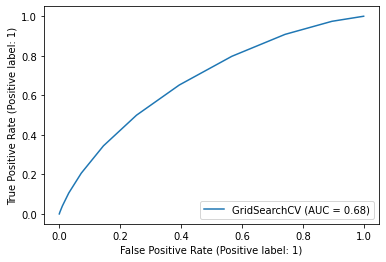

In [144]:
plot_roc_curve(knn_cv, X_test, y_test)
plt.show()

Model built with KNN has AUC score = 0.68.

And classification report:

In [134]:
y_true, y_pred_knn = y_test, knn_cv.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77     71517
           1       0.57      0.34      0.43     40103

    accuracy                           0.67    111620
   macro avg       0.64      0.60      0.60    111620
weighted avg       0.65      0.67      0.65    111620



### Decision Tree

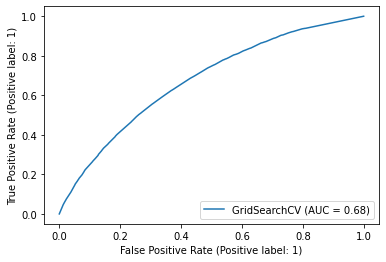

In [146]:
plot_roc_curve(tree_cv, X_test, y_test)
plt.show()

Model built with Decision Tree has AUC score = 0.68.

And classification report:

In [137]:
y_true, y_pred_tree = y_test, tree_cv.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76     71517
           1       0.54      0.40      0.46     40103

    accuracy                           0.66    111620
   macro avg       0.63      0.61      0.61    111620
weighted avg       0.65      0.66      0.65    111620



Both models have similar accuracy. Both are not as good as we would like to see :( 
    
![gif](https://media.giphy.com/media/9oF7EAvaFUOEU/giphy.gif)

But we expected such a result, because of available attributes are not so rich.
It would be nice to have more information about owners of projects, how much content projects have in an overview or even some economical features (inflation, GDP etc.)
